# Model Training


## Multilayered Precepton Network (MLP)
Proceeding the derivation of optimal feature sets with RFE for the region, we trained an ANN multilayer perceptron (MLP) regression model to estimate SWE.
The MLP is a classical type of feedforward ANN, being successfully and frequently applied in environmental modeling applications.
The MLP regression model estimates a target variable by learning a non-linear function to describe the target from an input vector of features.
It performs learning via a back-propagation algorithm over a series of hidden layers containing interconnected nodes (neurons). 
The neurons connect bordering layers by a summation of weights and an activation function transforms model outputs to predicted values (i.e., SWE (in)). 
The model calculates error and adjusts the weights to minimize the error during model training, supporting the use of 
MLPs to effectively describe a target variable with any function, continuous or discontinuous. 

Model training leveraged the Keras API within the TensorFlow library.
We selected the popular, open-source TensorFlow and Keras platforms for their wide applicability and capabilities in deep learning.
The MLP model for the region consists of an input layer containing nodes for each feature in the optimized feature space, 7 dense hidden layers, and an output layer of the target SWE value. 
Model formulation uses the Rectified Linear Unit (ReLu) activation function to transform each hidden layer to non-linearize the solution.

## Model Training Schema

Our motivation is to assess the model skill in extrapolating regional SWE dynamics from in-situ observations, thus, we use the same random 75-25\% train-test data split for the learning and validation of the model, respectively, compared to other methods (e.g., hold-one-out). 
Upon the completion of model training, model execution predicts 1-km resolution SWE magnitudes from data up to the current date of observation provided Latitude, Longitude, corresponding topographic data, and neighboring observation input features. From the sampling of test features, Chapter [Evaluation]('./evaluation.ipynb') compares the modeled 1-km grid SWE values to the observed values.




In [4]:
import os
from os import listdir
from os.path import isfile, join
import time
import re
import copy
import numpy as np
import pandas as pd
import h5py
import tables
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pickle 
import sklearn
from pickle import dump
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
import warnings; warnings.filterwarnings("ignore")

def atof(text):
    try:
        retval = float(text)
    except ValueError:
        retval = text
    return retval

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    float regex comes from https://stackoverflow.com/a/12643073/190597
    '''
    return [ atof(c) for c in re.split(r'[+-]?([0-9]+(?:[.][0-9]*)?|[.][0-9]+)', text) ]

In [5]:
def MLP_train_predict(Region_optfeatures, RegionTrain, Region, epochs, MLP_Models):
       
    #get y data
    y = RegionTrain[Region]['SWE']
    
    #get max SWE for normalization and prediction
    SWEmax = max(RegionTrain[Region]['SWE'])
    y = y/SWEmax

    #get optimal features for each regions (from LGBM RFE)
    optfeatures = list(Region_optfeatures[Region])
    
    #make a df copy of specific region
    df = RegionTrain.get(Region).copy()
    df = df[optfeatures]
    
    ### replace special character ':' with '__' 
    df = df.rename(columns = lambda x:re.sub(':', '__', x))

    #change all na values to prevent scaling issues
    df[df< -9000]= -10

    #normalize training data    
    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(df)
    df = pd.DataFrame(scaled, columns = df.columns)


    #Set the 75/25% train/test split, set a random state to get train/test for future analysis
    X = df
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1234)
    
    #set up prediction dataframe
    pred_obs = pd.DataFrame(y_test)
    pred_obs = pred_obs.rename(columns = {'SWE':'y_test'})
    
    
    #set up model checkpoint to be able to extract best models
    checkpointfilename ='SWE_{val_loss:.8f}.h5'
    checkpoint_filepath = 'Model/Model_Training/'+MLP_Models+'/' +Region+ '/'
    
    #save scaler data here too
    dump(scaler, open(checkpoint_filepath+'scaler.pkl', 'wb'))
    
    checkpoint_filename = checkpoint_filepath+checkpointfilename
    callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filename,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
    
     #need to save SWEmax
    SWEmax = np.array(SWEmax)
    np.save(checkpoint_filepath+'SWEmax.npy' , SWEmax)

    #get the training data shape to form MLP model input layer
    shape = X_train.shape

    #set up layer-nodes for MLP model
    LD1=128
    #seems like only slight increase in runtime with another layer
    LD2=128
    #seems like only slight increase in runtime with another layer
    LD3=64
    #seems like only slight increase in runtime with another layer, sig per improvement 
    LD4=64
    LD5=32
    LD6=16
    LD7=5

    input_1 = layers.Input(shape=(shape[1],))
    x = layers.Dense(LD1, activation="relu")(input_1)
    x = layers.Dense(LD2, activation="relu")(x)
    x = layers.Dense(LD3, activation="relu")(x)
    x = layers.Dense(LD4, activation="relu")(x)
    x = layers.Dense(LD5, activation="relu")(x)
    x = layers.Dense(LD6, activation="relu")(x)
    x = layers.Dense(1)(x)

    model = keras.Model(inputs=input_1,outputs=x)
    model.compile(loss='mse', optimizer=keras.optimizers.Adam(1e-4), metrics=['mse'])
    print(model.summary())
    
    model.fit(X_train, y_train, epochs=epochs, batch_size=100,
                        validation_data=(X_test,y_test),shuffle=True,callbacks=[callback], verbose=0)
    
    
    
     #load the model with highest performance
    bestmodel = [f for f in listdir(checkpoint_filepath) if isfile(join(checkpoint_filepath, f))]
    bestmodel.sort(key=natural_keys)
    bestmodel = checkpoint_filepath+bestmodel[0]
    model=load_model(bestmodel)
    print(bestmodel)
    
    
    #make predictions and rescale, the 10 is bc changed -9999 values to -10
    y_pred = (SWEmax* model.predict(X_test))
    
    #negative SWE is impossible, change negative values to 0
    y_pred[y_pred < 0 ] = 0
    y_test = (SWEmax * y_test)
    pred_obs['y_test'] = y_test
    pred_obs['y_pred'] = y_pred 
    pred_obs['Region'] = region
    
    #Run model evaluate function
    print(model.evaluate(X_train, y_train))
    r2_test = sklearn.metrics.r2_score(y_test, y_pred)
    rmse_test = sklearn.metrics.mean_squared_error(y_test, y_pred, squared = False)
    print(' R2 is ', r2_test)
    print(' RMSE is ', rmse_test)
    print("MSE: %.4f" % mean_squared_error(y_test, y_pred))
    
    error_data = np.array([region, round(r2_test,2),  round(rmse_test,2)])
    error = pd.DataFrame(data = error_data.reshape(-1, len(error_data)), columns = ['Region', 'R2', 'RMSE'])
    print(error)


    #plot graph
    plt.scatter( pred_obs['y_test'],pred_obs['y_pred'], s=5, color="blue", label="Predictions")
    plt.plot([0,SWEmax], [0,SWEmax], color = 'red', linestyle = '--')
    plt.xlabel('Observed SWE')
    plt.ylabel('Predicted SWE')

    #plt.plot(x_ax, y_pred, lw=0.8, color="red", label="predicted")
    plt.title(region)
    plt.legend()
    plt.show()
    
    return pred_obs, error

Training model for  N_Co_Rockies
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 35)]              0         
                                                                 
 dense_7 (Dense)             (None, 128)               4608      
                                                                 
 dense_8 (Dense)             (None, 128)               16512     
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dense_11 (Dense)            (None, 32)                2080      
                                                                 
 dense_12 (Dense)         

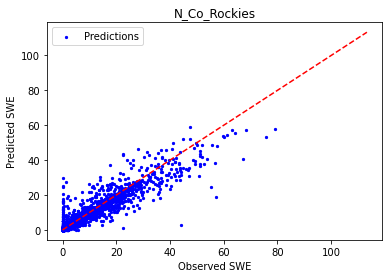

296.58772802352905 seconds


In [6]:
### define new regions
Region_list = [
               'N_Co_Rockies',
              ]

#make model file directories
#for region in Region_list:
 #   os.makedirs('Model/Model_Training/MLP/'+region)

#load RFE optimized features
Region_optfeatures= pickle.load(open("Model/Model_Features/Optimal_Features.pkl", "rb"))

### Load H5 train files into dictionary
RegionTrain= {}
for region in Region_list:
    RegionTrain[region] = pd.read_hdf('Provided_Data/Final_Training_DF.h5', region)
    
#Reorder regions
RegionTrain = {k: RegionTrain[k] for k in Region_list}

Model_Results= pd.DataFrame(columns = ['y_test', 'y_pred',  'Region'])
Model_Error = pd.DataFrame(columns = ['Region', 'R2', 'RMSE'])

t0 = time.time()
for region in Region_list:
    print('Training model for ', region)
    #Training model and getting results
    pred_obs, error = MLP_train_predict(Region_optfeatures, RegionTrain, region, 3000, 'MLP')
    Model_Results = Model_Results.append(pred_obs)
    Model_Error = Model_Error.append(error)
    #Save predictions
    pred_obs.to_hdf('Model/Model_Training/Model_Validation/Region_Predictions.h5', key= region, complevel = 9, complib = 'bzip2')
t1 = time.time()
print('Model training took ', t1-t0, 'seconds')

Next [Chapter](./evaluation.ipynb).